# mount drive

In [1]:
use_colaboratory = True
if use_colaboratory:
    import os
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/tabular-playground-series-mar-2022/notebook')

Mounted at /content/drive


In [2]:
# import packages
import datetime
import holidays
import itertools
import math
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

### 016-1
015-1(1学習データ全体の中央値，1日前，1週間前のシフト特徴量を追加)のカテゴリ変数をone-hot-encoding

In [29]:
# load data
train = pd.read_csv("../input/train.csv", index_col="row_id")
test = pd.read_csv("../input/test.csv", index_col="row_id")
train.time = pd.to_datetime(train.time)
test.time = pd.to_datetime(test.time)

In [30]:
# trainとtestをまとめる
data = pd.concat([train, test])
print(len(data))

851175


In [31]:
# 元データであるかどうかのフラグ
data["org"] = True

# 座標と方角をまとめた列を追加
data["loc_dir"] = data.x.astype("str") + data.y.astype("str") + data.direction

# 抜けたデータポイントを補う
time_index = pd.date_range(start=data.time.iloc[0], end=data.time.iloc[-1], freq="20min")
loc_dir = data.loc_dir.unique()
df = pd.DataFrame(list(itertools.product(time_index, loc_dir)), columns=["time","loc_dir"])
data = df.merge(data, how="left", on=["time", "loc_dir"])

# 追加した行のorgフラグはFalseにする
data.org.fillna(False, inplace=True)

In [32]:
# 時系列の特徴量を追加
data["hour"] = data.time.dt.hour
data["minute"] = data.time.dt.minute
data["weekday"] = data.time.dt.weekday
# data["dayofyear"] = data.time.dt.dayofyear
# data["weekofyear"] = data.time.dt.isocalendar().week
data["isPM"] = (data.hour >= 12).astype("int")
data["isAMrush"] = ((6 <= data.hour) & (data.hour <= 10)).astype("int")
data["isPMrush"] = ((15 <= data.hour) & (data.hour <= 20)).astype("int")
data["isweekend"] = (data.weekday >= 5).astype("int")
data["isnight"] = ((data.hour < 5) & (22 < data.hour)).astype("int")
us_holidays = holidays.US()
data["isholiday"] = (data.time.map(lambda x: x in us_holidays)).astype("int")

# trainデータから座標，方角，曜日，時，分ごとの中央値を計算
medians = data.iloc[:len(train)].groupby(["loc_dir", "weekday", "hour", "minute"]).congestion.median()
medians.name = "wd_h_min_median"
# 中央値を追加
data = data.merge(medians, how="left", left_on=["loc_dir", "weekday", "hour", "minute"], right_index=True)

In [33]:
# シフト特徴量のためのカラムを作製
data["shift_feature"] = data.congestion
# 欠損値は中央値で補完
data.shift_feature.fillna(data.wd_h_min_median, inplace=True)

# シフト特徴量作製のため，wide formatに変更
wide_shift_feature = data.pivot(index="time", columns="loc_dir", values="shift_feature")

# 1日，1週間のシフト特徴量を計算
shift_1d = wide_shift_feature.shift(3*24)
shift_1w = wide_shift_feature.shift(3*24*7)
# long formatに戻す
shift_1d = shift_1d.stack()
shift_1d.name = "shift_1d"
shift_1d = shift_1d.reset_index()
shift_1w = shift_1w.stack()
shift_1w.name = "shift_1w"
shift_1w = shift_1w.reset_index()

# 特徴量として追加
data = data.merge(shift_1d, how="left", on=["time", "loc_dir"])
data = data.merge(shift_1w, how="left", on=["time", "loc_dir"])

# 座標，方角，曜日，時間，分，をone-hot-encoding
data = pd.get_dummies(data, columns=["x", "y", "direction", "hour", "minute"])

# 元データのみ取り出す
data = data[data.org]

In [34]:
# trainとtestに再分割
train = data.iloc[:len(train)]
test = data.iloc[len(train):]

# 欠損値のある行を除く
train = train.dropna()

# 特徴量，目的変数に分ける
X_train = train.drop(["time", "loc_dir", "congestion", "shift_feature", "org"], axis=1)
y_train = train.congestion
X_test = test.drop(["time", "loc_dir", "congestion", "shift_feature", "org"], axis=1)

In [35]:
# 保存用の配列
y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv_idx = []


params = {
    "objective": "regression",
    "metric": "mae",
    "learning_rate": 0.05,
}

# 時系列で交差検証
cv = TimeSeriesSplit(n_splits=5)

for fold_idx, (tr_idx, val_idx) in enumerate(cv.split(X_train)):
    cv_idx.append({"train": tr_idx, "valid": val_idx})
    print(f"======== fold: {fold_idx} ========")

    # 学習用，バリデーション用に分割
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=3000,
                      early_stopping_rounds=10)
    
    oof_train[val_idx] = \
        model.predict(X_val, num_iteration=model.best_iteration)

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

======== fold: 0 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.81053	valid_1's l1: 9.79472
[20]	training's l1: 7.69219	valid_1's l1: 7.72035
[30]	training's l1: 6.65441	valid_1's l1: 6.71389
[40]	training's l1: 6.16779	valid_1's l1: 6.25372
[50]	training's l1: 5.93807	valid_1's l1: 6.04753
[60]	training's l1: 5.82745	valid_1's l1: 5.95454
[70]	training's l1: 5.77151	valid_1's l1: 5.91409
[80]	training's l1: 5.74502	valid_1's l1: 5.90165
[90]	training's l1: 5.72852	valid_1's l1: 5.89814
[100]	training's l1: 5.71701	valid_1's l1: 5.89791
[110]	training's l1: 5.70732	valid_1's l1: 5.89641
Early stopping, best iteration is:
[109]	training's l1: 5.70791	valid_1's l1: 5.89613
======== fold: 1 ========
Training until validation scores don't improve for 10 rounds.
[10]	training's l1: 9.81428	valid_1's l1: 9.98332
[20]	training's l1: 7.71696	valid_1's l1: 7.90834
[30]	training's l1: 6.68376	valid_1's l1: 6.88719
[40]	training's l1: 6.19694	valid_1'

In [36]:
with open("../output/y_preds_016-1.pkl", "wb") as f:
    pickle.dump(y_preds, f)

with open("../output/models_016-1.pkl", "wb") as f:
    pickle.dump(models, f)

with open("../output/oof_train_016-1.pkl", "wb") as f:
    pickle.dump(oof_train, f)

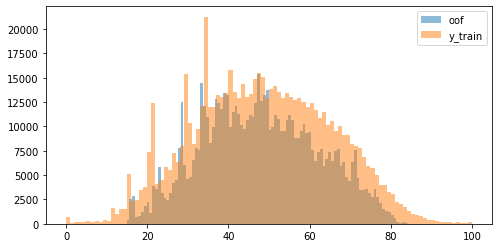

In [37]:
plt.figure(figsize=(8, 4))
plt.hist(oof_train[len(cv_idx[0]["train"]):], bins=100, label="oof", alpha=0.5)
plt.hist(train.iloc[len(cv_idx[0]["train"]):].congestion, bins=100, label="y_train", alpha=0.5)
plt.legend()
plt.show()

In [38]:
scores = [
    m.best_score["valid_1"]["l1"] for m in models
]
score = sum(scores) / len(scores)
print("=== CV scores ===")
print(scores)
print(score)

=== CV scores ===
[5.896127853450382, 6.010530456997391, 6.039728867282489, 5.943873485353659, 6.312074994340222]
6.040467131484829


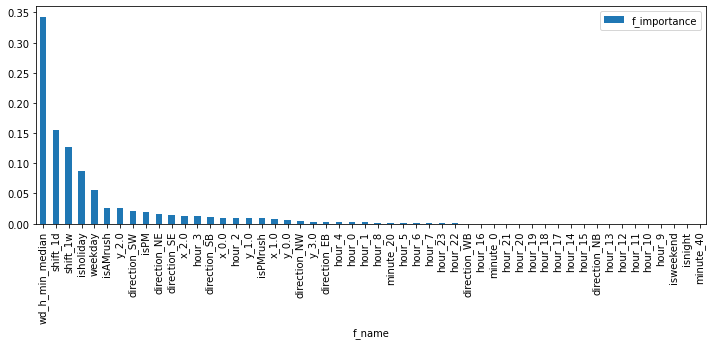

In [39]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)

f_importance = models[-1].feature_importance()
f_importance = f_importance / np.sum(f_importance)
f_name = models[-1].feature_name()

df_importance = pd.DataFrame({"f_name": f_name, "f_importance": f_importance})
df_importance = df_importance.sort_values("f_importance", ascending=False)

df_importance.plot.bar(x="f_name", ax=ax)

### submit

In [41]:
with open("../output/y_preds_016-1.pkl", "rb") as f:
    y_preds = pickle.load(f)

submission = pd.read_csv("../input/sample_submission.csv")
submission.congestion = y_preds[-1]

submission.to_csv("../submit/submission_016-1.csv", index=False)

In [42]:
import json
with open('../../kaggle.json') as f:
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

!pip install kaggle --upgrade
!kaggle -v

Kaggle API 1.5.12


In [43]:
# submission
!kaggle competitions submit tabular-playground-series-mar-2022 -f ../submit/submission_016-1.csv -m "016-1"

100% 57.5k/57.5k [00:00<00:00, 298kB/s]
Successfully submitted to Tabular Playground Series - Mar 2022